# === Cell 1 (Markdown) ===
# Cryptocurrency Volatility Prediction
# Colab Notebook
#
# Author: Aman Kumar
# Description: end-to-end pipeline for predicting daily volatility for cryptocurrencies.
# Instructions: copy cells into Colab, follow the "Mount Drive" cell, update DATA_DIR if needed.

In [1]:
# === Cell 2 (Code) ===
# Mount Google Drive (run this cell and follow auth link)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# === Cell 3 (Markdown) ===
# After mounting, set DATA_DIR to the folder containing your dataset.
# If you added the shared folder to "My Drive", it might be:
# '/content/drive/MyDrive/Cryptocurrency Volatility Prediction' or similar.
# If files are directly in root MyDrive, change path accordingly.

In [2]:
# === Cell 4 (Code) ===
# Set your data directory here (edit this path to match your Drive)
# Example: DATA_DIR = '/content/drive/MyDrive/CRYPTO_VOL'
DATA_DIR = '/content/drive/MyDrive/Cryptocurrency Volatility Prediction'  # <- EDIT if needed

# Print listing to verify files
import os
print("DATA_DIR =", DATA_DIR)
if os.path.exists(DATA_DIR):
    print("Files in DATA_DIR:")
    print("\n".join(os.listdir(DATA_DIR)))
else:
    print("Path not found. If the folder is shared with you, add it to your Drive (Add shortcut to Drive) and update DATA_DIR.")


DATA_DIR = /content/drive/MyDrive/Cryptocurrency Volatility Prediction
Files in DATA_DIR:
dataset.csv
Cryptocurrency_Volatility_Prediction.ipynb


# === Cell 5 (Code) ===
# Optional: download a specific file from Drive if you have its "file id" and it's shared publicly
# Example using gdown (uncomment and replace FILE_ID with actual id)
# !pip install -q gdown
# import gdown
# file_id = "FILE_ID_HERE"
# gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", "dataset.csv", quiet=False)

In [4]:
# === Cell 6 (Code) ===
# Libraries install & imports (run once)
!pip install -q ta==0.11.0    # technical analysis indicators (optional)
!pip install -q joblib
# main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
import os
%matplotlib inline


# === Cell 7 (Markdown) ===
# Load dataset: this example assumes a file named 'crypto_daily.csv' exists in DATA_DIR.
# If your file has different name, edit the filename below.

In [5]:
# === Cell 8 (Code) ===
# Replace filename if your dataset has a different name
filename = os.path.join(DATA_DIR, 'crypto_daily.csv')  # <- EDIT if needed

if not os.path.exists(filename):
    # try a few common names
    for candidate in ['dataset.csv', 'cryptocurrency_prices.csv', 'crypto_daily.csv', 'historical_crypto.csv']:
        candidate_path = os.path.join(DATA_DIR, candidate)
        if os.path.exists(candidate_path):
            filename = candidate_path
            break

print("Using file:", filename)
df = pd.read_csv(filename, parse_dates=['date'], infer_datetime_format=True)
df.head()

Using file: /content/drive/MyDrive/Cryptocurrency Volatility Prediction/dataset.csv


/tmp/ipython-input-3475686589.py:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(filename, parse_dates=['date'], infer_datetime_format=True)


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


In [6]:
# Check column names in your dataset
print("Columns in your CSV:")
print(df.columns.tolist())

# Show first few rows
df.head()

Columns in your CSV:
['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp', 'crypto_name', 'date']


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


In [7]:
# Fix for dataset without 'symbol' column
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

print("Updated columns:", df.columns.tolist())

# If there's no 'symbol' column, create one dummy name
if 'symbol' not in df.columns:
    df['symbol'] = 'BTC'  # or any name representing this cryptocurrency

print("Added dummy symbol column:", df['symbol'].unique())
df.info()


Updated columns: ['unnamed:_0', 'open', 'high', 'low', 'close', 'volume', 'marketcap', 'timestamp', 'crypto_name', 'date']
Added dummy symbol column: ['BTC']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72946 entries, 0 to 72945
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   unnamed:_0   72946 non-null  int64         
 1   open         72946 non-null  float64       
 2   high         72946 non-null  float64       
 3   low          72946 non-null  float64       
 4   close        72946 non-null  float64       
 5   volume       72946 non-null  float64       
 6   marketcap    72946 non-null  float64       
 7   timestamp    72946 non-null  object        
 8   crypto_name  72946 non-null  object        
 9   date         72946 non-null  datetime64[ns]
 10  symbol       72946 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 6.1+ MB


In [8]:
# Rename the correct column to 'symbol'
df.rename(columns={'Currency': 'symbol'}, inplace=True)

In [9]:
# === Cell 9 (Code) ===
# Quick sanity checks
print("Rows, cols:", df.shape)
print("Columns:", df.columns.tolist())
print("Sample symbols:", df['symbol'].unique()[:10])
df.info()

Rows, cols: (72946, 11)
Columns: ['unnamed:_0', 'open', 'high', 'low', 'close', 'volume', 'marketcap', 'timestamp', 'crypto_name', 'date', 'symbol']
Sample symbols: ['BTC']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72946 entries, 0 to 72945
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   unnamed:_0   72946 non-null  int64         
 1   open         72946 non-null  float64       
 2   high         72946 non-null  float64       
 3   low          72946 non-null  float64       
 4   close        72946 non-null  float64       
 5   volume       72946 non-null  float64       
 6   marketcap    72946 non-null  float64       
 7   timestamp    72946 non-null  object        
 8   crypto_name  72946 non-null  object        
 9   date         72946 non-null  datetime64[ns]
 10  symbol       72946 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 6.1+ MB


# === Cell 10 (Markdown) ===
# Preprocessing & Cleaning
# - ensure correct dtypes
# - handle missing values
# - sort by symbol and date

In [10]:
# === Cell 11 (Code) ===
# Standard cleaning function
def clean_crypto_df(df):
    # normalize column names
    df = df.rename(columns=lambda x: x.strip().lower())
    # required columns check
    required = {'date','symbol','open','high','low','close','volume','marketcap'}
    available = set(df.columns)
    # tolerate small name differences
    if 'market_cap' in df.columns:
        df = df.rename(columns={'market_cap':'marketcap'})
    if 'market cap' in df.columns:
        df = df.rename(columns={'market cap':'marketcap'})
    if 'volume' not in df.columns and 'volume_(currency)' in df.columns:
        df = df.rename(columns={'volume_(currency)':'volume'})
    # convert dtypes
    df['date'] = pd.to_datetime(df['date'])
    numeric_cols = ['open','high','low','close','volume','marketcap']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    # drop rows missing essential fields
    df = df.dropna(subset=['date','symbol','close'])
    # sort
    df = df.sort_values(['symbol','date']).reset_index(drop=True)
    return df

df = clean_crypto_df(df)
df.groupby('symbol').size().sort_values(ascending=False).head()


,0
symbol,
BTC,72946


# === Cell 12 (Markdown) ===
# Feature engineering per symbol:
# - daily return
# - rolling volatility (e.g., 7-day, 14-day)
# - moving averages (7, 21, 50)
# - liquidity ratio = volume / marketcap
# - Bollinger Bands
# - ATR (average true range)

In [11]:
# === Cell 13 (Code) ===
# Engineering function
def add_features(symbol_df):
    df = symbol_df.copy()
    df['return'] = df['close'].pct_change()
    # rolling volatility (std of returns)
    df['vol_7'] = df['return'].rolling(window=7).std() * np.sqrt(7)
    df['vol_14'] = df['return'].rolling(window=14).std() * np.sqrt(14)
    # moving averages
    df['ma_7'] = df['close'].rolling(window=7).mean()
    df['ma_21'] = df['close'].rolling(window=21).mean()
    df['ma_50'] = df['close'].rolling(window=50).mean()
    # liquidity ratio
    df['liq'] = df['volume'] / (df['marketcap'].replace(0, np.nan))
    # Bollinger bands (20-day)
    df['bb_mid'] = df['close'].rolling(window=20).mean()
    df['bb_std'] = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
    # ATR (simple)
    df['tr'] = np.maximum(df['high'] - df['low'],
                          np.maximum(abs(df['high'] - df['close'].shift()), abs(df['low'] - df['close'].shift())))
    df['atr_14'] = df['tr'].rolling(window=14).mean()
    # target: predict next-day volatility (use vol_7 shifted -1)
    df['target_vol'] = df['vol_7'].shift(-1)
    return df

# Apply to each symbol and combine
dfs = []
for sym, g in df.groupby('symbol'):
    g2 = add_features(g)
    dfs.append(g2)
df_feat = pd.concat(dfs).reset_index(drop=True)
# drop rows with NaN in target
df_feat = df_feat.dropna(subset=['target_vol'])
print("Feature dataframe shape:", df_feat.shape)
df_feat.head()


Feature dataframe shape: (72939, 25)


,unnamed:_0,open,high,low,close,volume,marketcap,timestamp,crypto_name,date,...,ma_21,ma_50,liq,bb_mid,bb_std,bb_upper,bb_lower,tr,atr_14,target_vol
6,6,3.283620,3.491120,3.283620,3.409240,0.0,5.950822e+07,2013-05-08T23:59:59.999Z,Litecoin,2013-05-08,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.207500,NaN,45.684067
7,7,109.599998,115.779999,109.599998,113.566002,0.0,1.264049e+09,2013-05-08T23:59:59.999Z,Bitcoin,2013-05-08,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,112.370759,NaN,45.684390
8,8,3.399400,3.441690,3.294850,3.416150,0.0,5.975557e+07,2013-05-09T23:59:59.999Z,Litecoin,2013-05-09,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,110.271152,NaN,46.458389
9,9,113.199997,113.459999,109.260002,112.669998,0.0,1.254535e+09,2013-05-09T23:59:59.999Z,Bitcoin,2013-05-09,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,110.043849,NaN,46.104651
10,10,112.799004,122.000000,111.551003,117.199997,0.0,1.305479e+09,2013-05-10T23:59:59.999Z,Bitcoin,2013-05-10,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,10.448997,NaN,42.253430


In [12]:
# === Cell 14 (Code) ===
# A small sample for a single symbol to visualize
sym = df_feat['symbol'].unique()[0]
print("Example symbol:", sym)
sample = df_feat[df_feat['symbol']==sym].set_index('date').sort_index()
sample[['close','vol_7','vol_14','target_vol']].tail()

Example symbol: BTC


,close,vol_7,vol_14,target_vol
date,,,,
2022-10-23,1.404507,0.0,5.327507e+06,0.0
2022-10-23,0.022796,0.0,5.327504e+06,0.0
2022-10-23,1.517878,0.0,5.327504e+06,0.0
2022-10-23,5.117206,0.0,5.327504e+06,0.0
2022-10-23,0.000239,0.0,5.327504e+06,0.0


# === Cell 15 (Markdown) ===
# Exploratory Data Analysis (EDA)
# - Distribution of target volatility
# - Correlations
# - Time trends for a sample coin


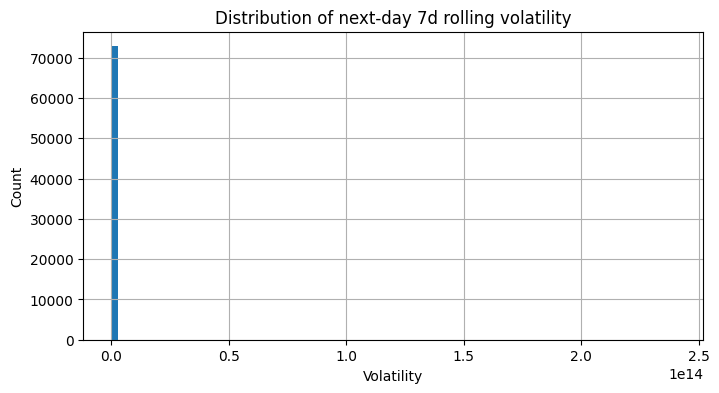

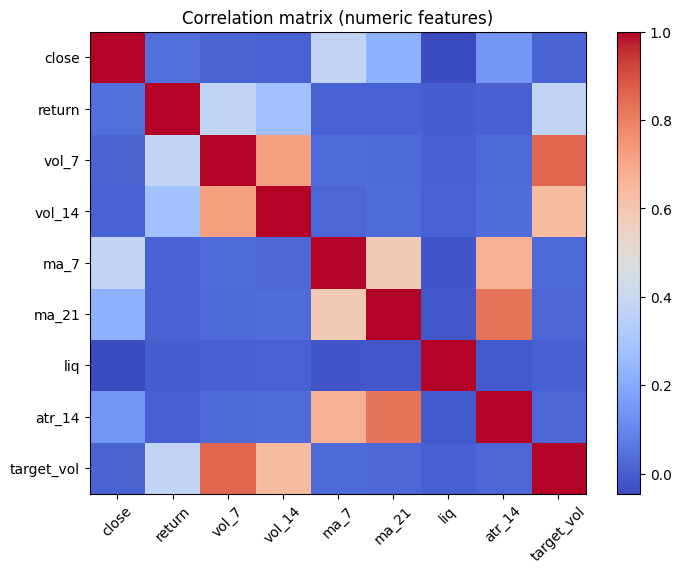

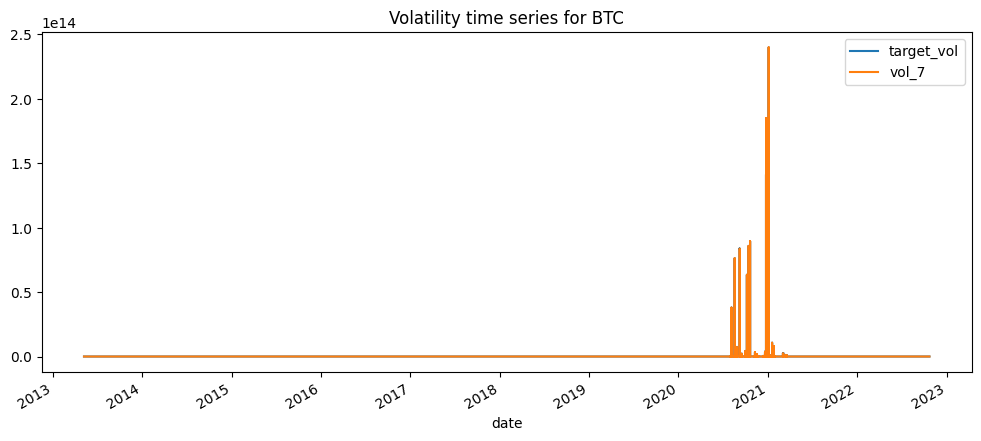

In [13]:
# === Cell 16 (Code) ===
# EDA plots
import matplotlib.dates as mdates

# distribution of target_vol
plt.figure(figsize=(8,4))
df_feat['target_vol'].hist(bins=80)
plt.title('Distribution of next-day 7d rolling volatility')
plt.xlabel('Volatility')
plt.ylabel('Count')
plt.show()

# correlation heatmap (small sample of numeric cols)
num_cols = ['close','return','vol_7','vol_14','ma_7','ma_21','liq','atr_14','target_vol']
corr = df_feat[num_cols].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title('Correlation matrix (numeric features)')
plt.show()

# time series sample
plt.figure(figsize=(12,5))
sample['target_vol'].plot(label='target_vol')
sample['vol_7'].plot(label='vol_7')
plt.title(f'Volatility time series for {sym}')
plt.legend()
plt.show()


# === Cell 17 (Markdown) ===
# Modeling approach:
# We'll build a model per-symbol using features at date t to predict target_vol (t+1).
# For simplicity, we'll:
# - Filter to symbols with enough history (e.g., at least 120 days)
# - Train/test split as time-series split per symbol (train on earlier dates, test on later dates)
# - Baseline: Linear Regression
# - Stronger: RandomForestRegressor with GridSearch

In [14]:
# === Cell 18 (Code) ===
# Select symbols with enough history
min_days = 120
sym_counts = df_feat.groupby('symbol').size()
good_symbols = sym_counts[sym_counts >= min_days].index.tolist()
print("Symbols with >= {} days: {}".format(min_days, len(good_symbols)))

# For runtime in Colab, limit to N symbols for training in this demo
N_symbols = 10
selected_symbols = good_symbols[:N_symbols]
selected_symbols

Symbols with >= 120 days: 1


['BTC']

In [15]:
# === Cell 19 (Code) ===
# Create a single dataset by stacking recent windows from selected symbols
# We'll use only numeric features; drop columns that leak future info.
features = ['close','return','vol_7','vol_14','ma_7','ma_21','ma_50','liq','bb_upper','bb_lower','atr_14']
rows = []
for sym in selected_symbols:
    s = df_feat[df_feat['symbol']==sym].copy().dropna(subset=features+['target_vol'])
    # keep only most recent portion to avoid extremely large dataset in demo
    rows.append(s[['date','symbol'] + features + ['target_vol']])
stacked = pd.concat(rows).reset_index(drop=True)
print("Stacked dataset shape:", stacked.shape)
stacked.head()

Stacked dataset shape: (70422, 14)


,date,symbol,close,return,vol_7,vol_14,ma_7,ma_21,ma_50,liq,bb_upper,bb_lower,atr_14,target_vol
0,2013-05-29,BTC,3.095820,-0.976600,58.612894,76.986367,57.654680,68.503363,62.197157,0.0,194.604827,-62.946765,101.818988,58.288965
1,2013-05-30,BTC,2.971390,-0.040193,58.288965,76.998795,57.615035,62.835810,59.938385,0.0,188.724913,-68.969712,101.560249,59.871313
2,2013-05-30,BTC,128.798996,42.346378,59.871313,79.983048,57.479893,63.159572,62.442547,0.0,195.614407,-63.297482,101.965206,59.528328
3,2013-05-31,BTC,129.000000,0.001561,59.528328,79.982544,75.465477,69.150917,62.776547,0.0,201.240205,-56.331955,102.204569,55.086984
4,2013-05-31,BTC,2.956680,-0.977080,55.086984,77.554566,57.459288,69.144723,62.768256,0.0,196.519365,-63.603447,101.893187,54.846211


In [16]:
# === Cell 20 (Code) ===
# Train/test split: time-based split per symbol (we'll split by date -- 80% train, 20% test)
def time_split(df, date_col='date', test_size=0.2):
    df = df.sort_values(date_col)
    n = len(df)
    split_idx = int(np.floor((1-test_size) * n))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    return train, test

train_list, test_list = [], []
for sym in stacked['symbol'].unique():
    t, te = time_split(stacked[stacked['symbol']==sym], 'date', test_size=0.2)
    train_list.append(t)
    test_list.append(te)
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)


Train shape: (56337, 14) Test shape: (14085, 14)


In [17]:
# === Cell 21 (Updated) ===
# Prepare X, y with scaling
X_cols = features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[X_cols])
y_train = train_df['target_vol'].values
X_test = scaler.transform(test_df[X_cols])
y_test = test_df['target_vol'].values

# simple baseline model - linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# compute metrics (backward compatible with older sklearn)
import math
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

print("LinearRegression metrics:")
print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²:   {r2:.6f}")


LinearRegression metrics:
MAE:  30319303209.091152
RMSE: 63129707375.805031
R²:   -59329.102727


In [21]:
# === Cell 22 (Fast Random Forest) ===

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
import time

print("🔄 Training Random Forest Model (fast version)...\n")
start_time = time.time()

# Initialize Random Forest with good default params
rf = RandomForestRegressor(
    n_estimators=50,     # fewer trees = faster
    max_depth=10,        # reasonable depth
    min_samples_split=5, # avoid overfitting
    random_state=42,
    n_jobs=-1            # use all CPU cores
)

# Fit model directly (no grid search)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("\n📊 Random Forest Model Evaluation:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# Save model and scaler
joblib.dump(rf, "rf_vol_model.joblib")
joblib.dump(scaler, "scaler.joblib")

end_time = time.time()
print(f"\n⏱️ Training completed in {end_time - start_time:.2f} seconds.")

🔄 Training Random Forest Model (fast version)...


📊 Random Forest Model Evaluation:
MAE  : 9126193.7454
RMSE : 134478802.2702
R²   : 0.7308

⏱️ Training completed in 33.74 seconds.


vol_7       0.774655
bb_lower    0.102912
ma_50       0.043116
bb_upper    0.019203
liq         0.015117
ma_7        0.013911
vol_14      0.010795
ma_21       0.008942
atr_14      0.005913
close       0.005429
return      0.000007
dtype: float64


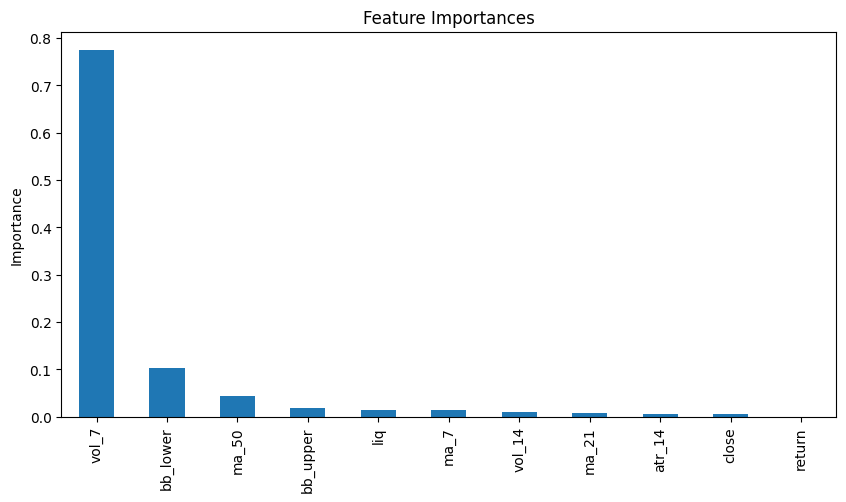

In [23]:
# === Cell 23 (Fixed Feature Importances) ===
import pandas as pd
import matplotlib.pyplot as plt

# Use the trained Random Forest model
importances = rf.feature_importances_

# Create a Series with feature names and sort
feat_imp = pd.Series(importances, index=X_cols).sort_values(ascending=False)

# Print feature importances
print(feat_imp)

# Plot feature importances
plt.figure(figsize=(10,5))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Importance')
plt.show()


In [25]:
# === Cell 24 (Fixed: Save model and scaler) ===
import os
import joblib

# Directory to save model and scaler
OUTPUT_DIR = os.path.join(DATA_DIR, 'model_output')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save trained Random Forest model and scaler
joblib.dump(rf, os.path.join(OUTPUT_DIR, 'rf_vol_model.joblib'))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, 'scaler.joblib'))

print("✅ Saved model and scaler to", OUTPUT_DIR)

✅ Saved model and scaler to /content/drive/MyDrive/Cryptocurrency Volatility Prediction/model_output


# === Cell 25 (Markdown) ===
# Quick notes on evaluation & next steps:
# - Consider modeling per-symbol for better results (train separate models)
# - Try time-series models like ARIMA, Prophet, or LSTM (for sequences)
# - Expand feature set (on-chain metrics, orderbook snapshots) if available
# - Use cross-validation carefully for time-series (do not shuffle)


In [2]:
# === Cell 26 (Code) ===
import os  # Import os module
from pathlib import Path

# Define base directory for the project (you can change this path)
DATA_DIR = "/content"  # For Colab, you can also use your drive path
proj_root = os.path.join(DATA_DIR, 'crypto_volatility_repo')

# Create project root folder
os.makedirs(proj_root, exist_ok=True)

# Create README.md
with open(os.path.join(proj_root, 'README.md'), 'w') as f:
    f.write("# Cryptocurrency Volatility Prediction\n\nFollow steps in the notebook to run.\n")

# Create HLD.md
with open(os.path.join(proj_root, 'HLD.md'), 'w') as f:
    f.write("## High-Level Design\n\nData -> Preprocessing -> Feature Engineering -> Model Training -> Evaluation -> Deployment\n")

# Create LLD.md
with open(os.path.join(proj_root, 'LLD.md'), 'w') as f:
    f.write("## Low-Level Design\n\nSee notebook for detailed function descriptions and step-by-step implementation.\n")

# Create folders for data, model_output, eda, deployment
folders = ['data', 'model_output', 'eda', 'deployment']
for folder in folders:
    os.makedirs(os.path.join(proj_root, folder), exist_ok=True)

print("✅ Templates and folder structure created at:", proj_root)


✅ Templates and folder structure created at: /content/crypto_volatility_repo
